# Obtención del dataset y preprocesamiento de las imágenes:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Correccion temporal (22/mayo/2022)
#Tensorflow datasets tiene error al descargar el set de perros y gatos y lo solucionaron
#el 16 de mayo pero sigue fallando en los colabs. Entonces se agrega esta linea adicional
#Mas detalle aqui: https://github.com/tensorflow/datasets/issues/3918
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

#Descargar el set de datos de perros y gatos
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
#Imprimir los metadatos para revisarlos
metadatos

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path=PosixGPath('/tmp/tmpb3vj97mutfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
  

In [ ]:
print(datos)

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


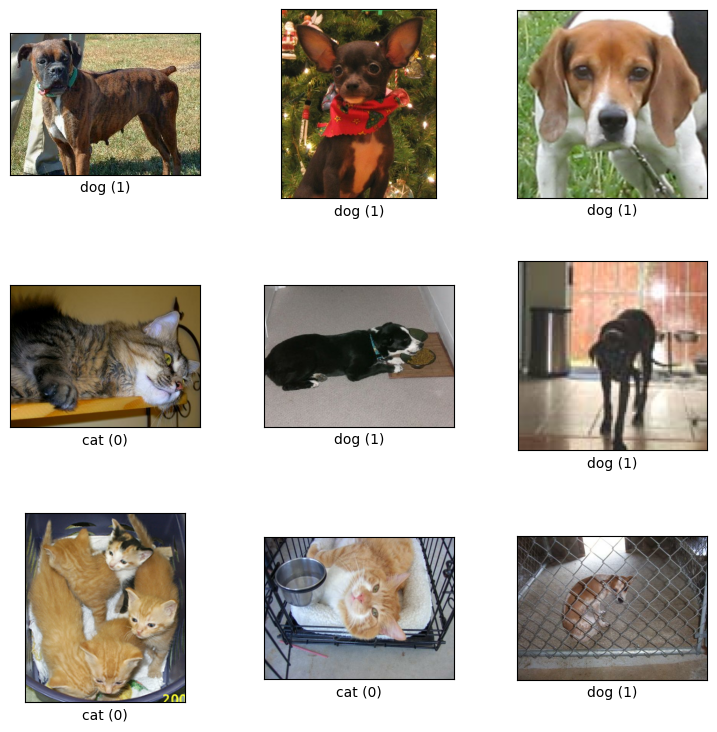

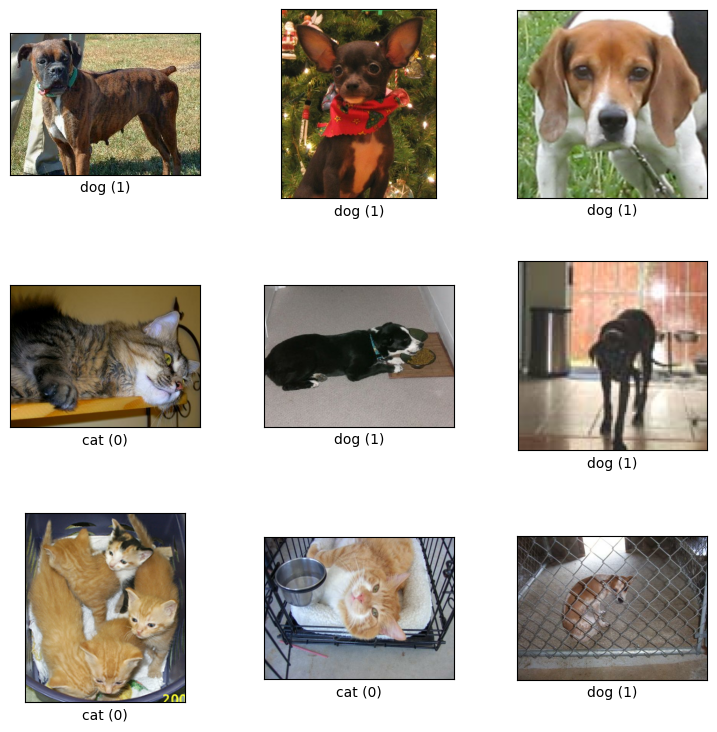

In [ ]:
# Mostramos ejémplos del dataset
tfds.show_examples(datos['train'], metadatos)

<ipython-input-14-c71e333295f9>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5, i+1)


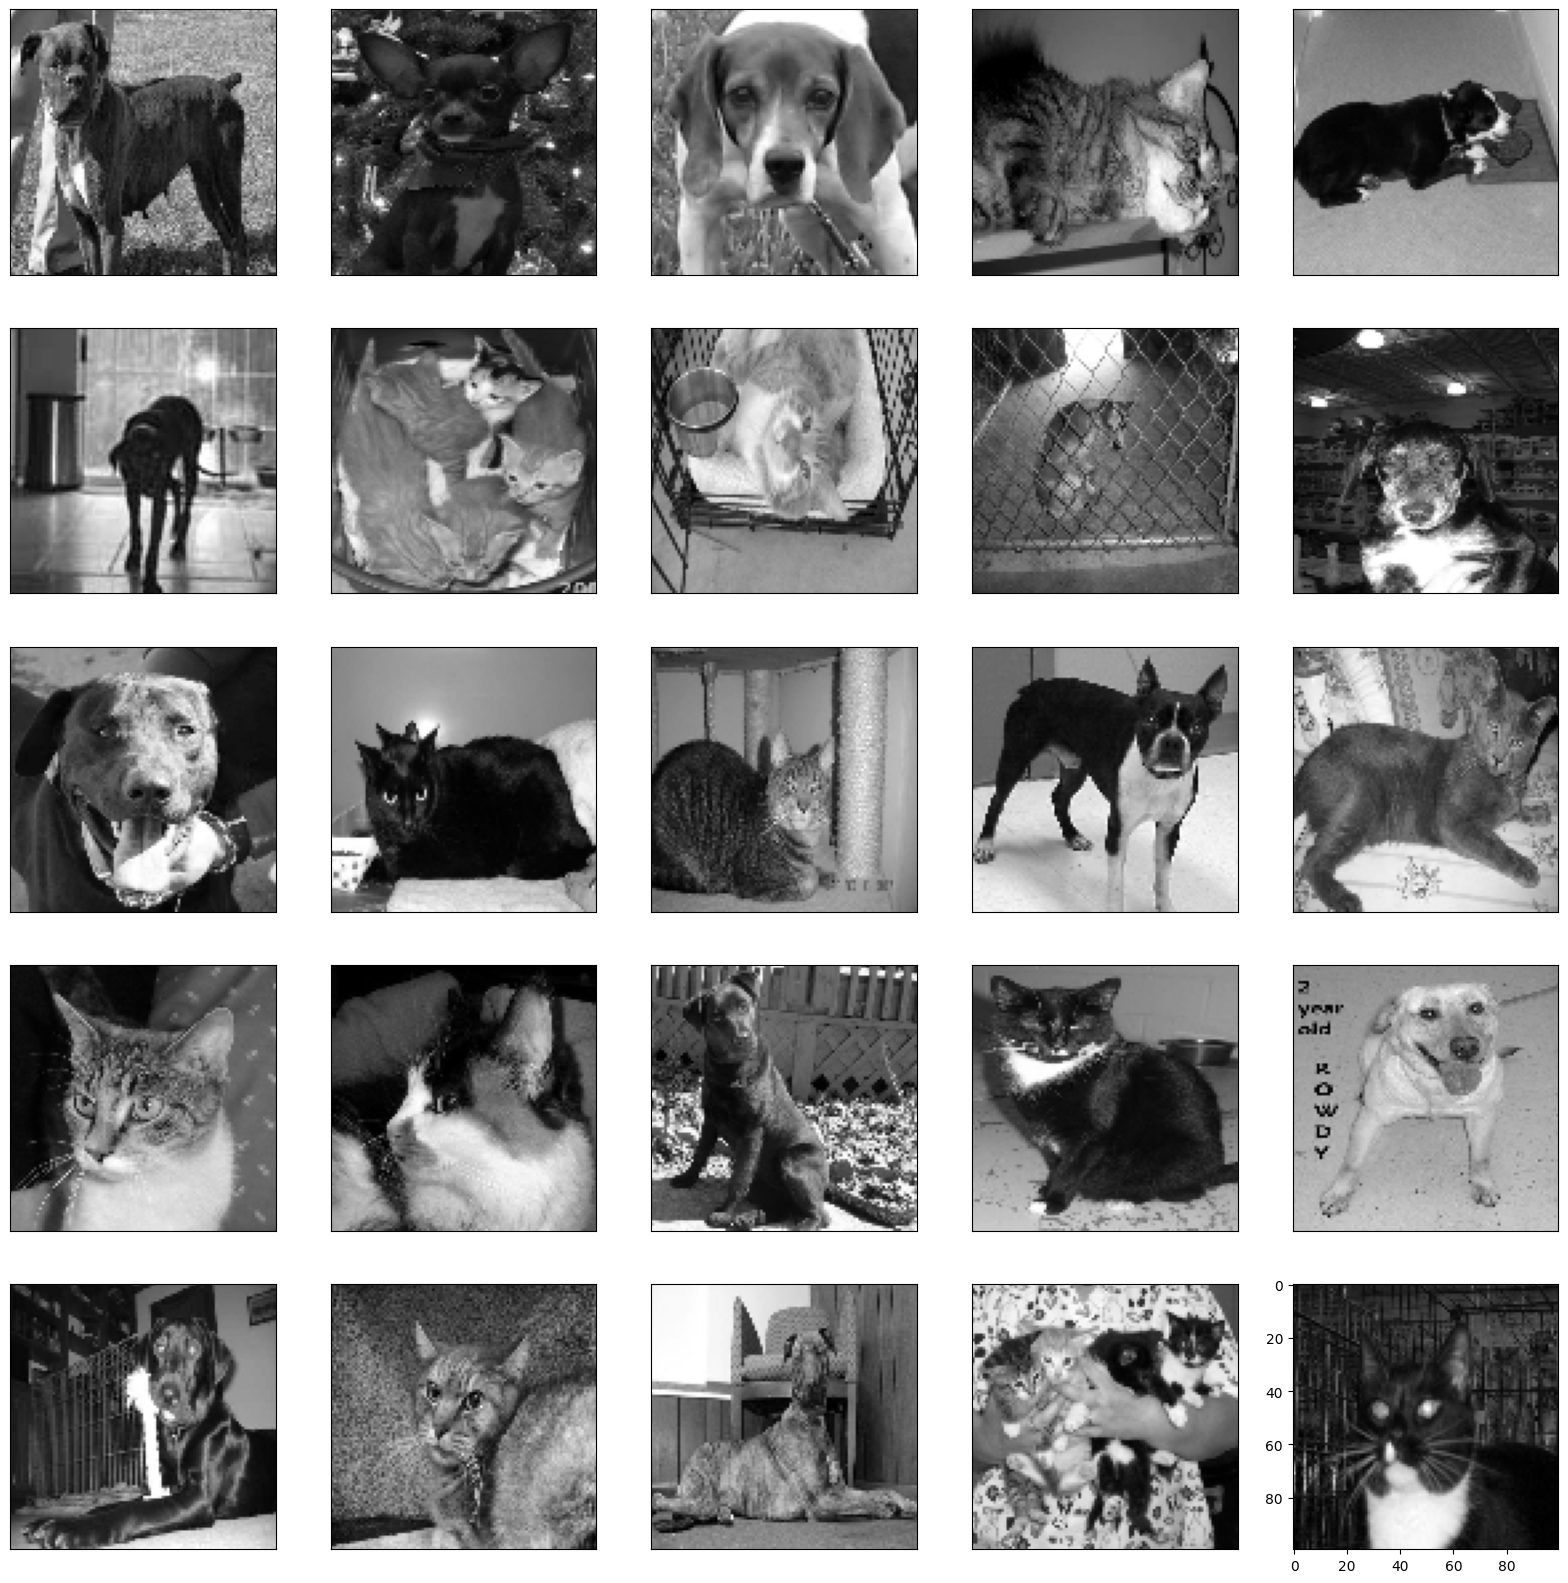

In [ ]:
import matplotlib.pyplot as plt
import cv2



plt.figure(figsize=(20,20))

TAMANO_IMG = 100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,5, i+1)
  plt.imshow(imagen, cmap='gray')

In [ ]:
datos_entrenamiento = []
X = []
Y = []

In [ ]:
# Rellenamos los datos con las imágenes en blanco y negro y reducidas a un tamaño 100x100
for i, (imagen, etiqueta) in enumerate(datos['train']):  
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) # Tenemos que especificar que es un tensor de 100x100x1
  datos_entrenamiento.append([imagen, etiqueta])
  X.append(imagen)
  Y.append(etiqueta)
  

In [ ]:
print(len(datos_entrenamiento))

23262


In [ ]:
import numpy as np
# Normalizamos los datos de las imágenes
X = np.array(X).astype(float) / 255
# Convierto Y en un array de numpy de 0 y 1 (originalmente son tensores)
Y = np.array(Y)

In [ ]:
print(X.shape)
print(Y.shape)

(23262, 100, 100, 1)
(23262,)


# Comenzamos a diseñar el modelo:

## Modelo denso: (feedforward)

In [ ]:
# creamos el modelo con keras
modeloDenso = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(100,100,1)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloDenso.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Modelo Red Neuronal Convolucional

In [ ]:
# creamos el modelo con keras
modeloCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ahora empezamos a entrenar a nuestros modelos:

In [ ]:
# Vamos a usar TensorBoard para ver la eficiencia de los modelos durante el entrenamiento:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
tensorboardDenso = TensorBoard(log_dir='logs(denso)')
modeloDenso.fit(X, Y, batch_size=32, validation_split=0.15, epochs=100,callbacks=[tensorboardDenso])

Epoch 1/100
618/618 [==============================] - 5s 5ms/step - loss: 0.7219 - accuracy: 0.5373 - val_loss: 0.6925 - val_accuracy: 0.5590
Epoch 2/100
618/618 [==============================] - 3s 4ms/step - loss: 0.6753 - accuracy: 0.5809 - val_loss: 0.6717 - val_accuracy: 0.5868
Epoch 3/100
618/618 [==============================] - 3s 4ms/step - loss: 0.6678 - accuracy: 0.5886 - val_loss: 0.6830 - val_accuracy: 0.5691
Epoch 4/100
618/618 [==============================] - 3s 6ms/step - loss: 0.6649 - accuracy: 0.5967 - val_loss: 0.6747 - val_accuracy: 0.5997
Epoch 5/100
618/618 [==============================] - 3s 4ms/step - loss: 0.6634 - accuracy: 0.6001 - val_loss: 0.6652 - val_accuracy: 0.6043
Epoch 6/100
618/618 [==============================] - 5s 8ms/step - loss: 0.6595 - accuracy: 0.6066 - val_loss: 0.6677 - val_accuracy: 0.5905
Epoch 7/100
618/618 [==============================] - 7s 12ms/step - loss: 0.6604 - accuracy: 0.6057 - val_loss: 0.6647 - val_accuracy: 0.600

In [ ]:
tensorboardCNN = TensorBoard(log_dir='logs(CNN)')
modeloCNN.fit(X, Y, batch_size=32, validation_split=0.15, epochs=100,callbacks=[tensorboardCNN])

Epoch 1/100
618/618 [==============================] - 15s 14ms/step - loss: 0.6357 - accuracy: 0.6217 - val_loss: 0.5554 - val_accuracy: 0.7238
Epoch 2/100
618/618 [==============================] - 8s 12ms/step - loss: 0.4966 - accuracy: 0.7598 - val_loss: 0.4901 - val_accuracy: 0.7610
Epoch 3/100
618/618 [==============================] - 7s 12ms/step - loss: 0.4172 - accuracy: 0.8095 - val_loss: 0.3959 - val_accuracy: 0.8226
Epoch 4/100
618/618 [==============================] - 8s 12ms/step - loss: 0.3688 - accuracy: 0.8344 - val_loss: 0.4072 - val_accuracy: 0.8138
Epoch 5/100
618/618 [==============================] - 7s 12ms/step - loss: 0.3228 - accuracy: 0.8589 - val_loss: 0.3641 - val_accuracy: 0.8375
Epoch 6/100
618/618 [==============================] - 8s 12ms/step - loss: 0.2867 - accuracy: 0.8792 - val_loss: 0.3477 - val_accuracy: 0.8447
Epoch 7/100
618/618 [==============================] - 8s 12ms/step - loss: 0.2372 - accuracy: 0.9003 - val_loss: 0.3382 - val_accuracy

## Forma más simple de guardar un modelo:

model.save('path_to_my_model.h5')
del model
model = keras.models.load_model('path_to_my_model.h5')

In [ ]:
modeloCNN.save('modelCNN')
modeloDenso.save('modelDense')

In [ ]:
import shutil
# Vamos a comprimir la carpeta del modelo para luego descargarlo
# Comprimir la carpeta del modelo en un archivo ZIP
shutil.make_archive("/content/modeloCNN", 'zip', "/content/modelCNN")

'/content/modeloCNN.zip'

In [ ]:
modelCNN_cargado = tf.keras.models.load_model('modelCNN')

In [ ]:
modelCNN_cargado.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 128)     

## Ahora vamos a hacer predicciones:

In [ ]:
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir logs(CNN)
%tensorboard --logdir logs(denso)

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-05-31 19:45:54.314608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
W0531 19:45:55.980344 139984834881280 plugin_event_accumulator.py:369] Found more than one graph event per run, or t

## Vemos que la CNN tiene mucho sobreajuste, así que vamos a ver como lo solucionamos:

In [ ]:
import gc
gc.collect()

42

# Vamos a hacer predicciones

In [ ]:
x_test = []
y_test = []

In [ ]:
Pcnn = modeloCNN.predict(X)

727/727 [==============================] - 3s 3ms/step


In [ ]:
import numpy as np

In [ ]:
plt.figure(figsize=(10,20))
for i in range(5):
  plt.subplot(1, 5, i+1)
  j = np.random.randint(0,10000)
  plt.imshow(X[j], cmap='gray')
  
  print(np.round(Pcnn[j]))

[1.]
[0.]
[1.]
[1.]
[0.]
